In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

## Create dataset for regression

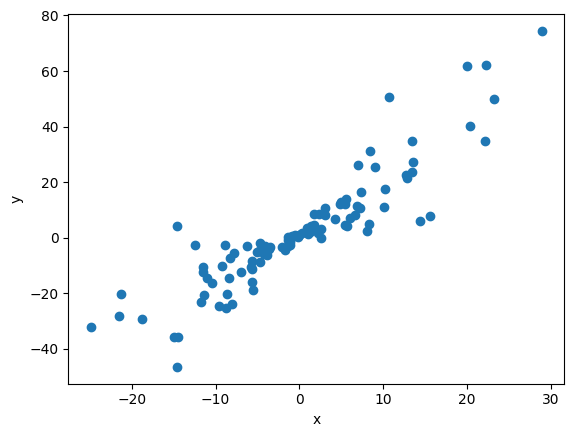

In [2]:
x = torch.randn(100, 1) * 10
y = 2*x + 1 + x * torch.randn(100, 1)

plt.plot(x.numpy(), y.numpy(), 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Test basic model

In [3]:
class CompressedModel(nn.Module):
    def __init__(self, a_init, a_index, tau=1):
        super().__init__()
        self.a = nn.Parameter(a_init)
        self.a_index = a_index
        self.tau = tau
    
    def forward(self, x):
        ## x shape [B, n]
        y = nn.Sigmoid()((x[:,self.a_index]-self.a) / self.tau)
        return y

In [4]:
a_init = torch.tensor([-15.,-5.,5.,15.], requires_grad=True)
a_index = torch.tensor([0,0,0,0])

model = CompressedModel(a_init, a_index)
output = model(x.view(-1,1))

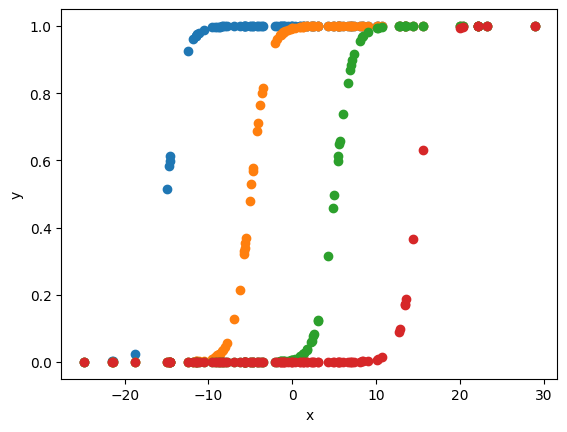

In [5]:
plt.figure()

for f in range(4):
    plt.plot(x.numpy(), output[:,f].detach().numpy(), 'o')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
model.tau = model.tau / 10
output = model(x.view(-1,1))

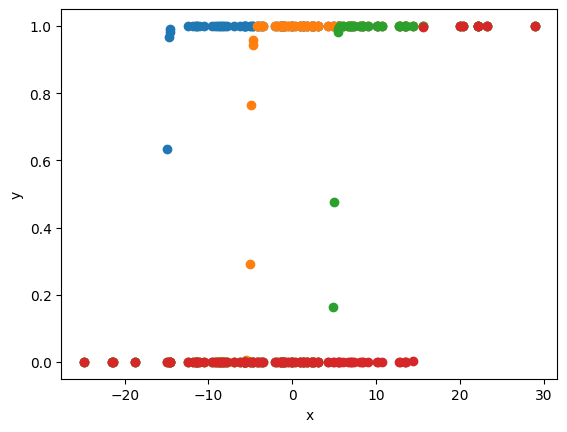

In [7]:
plt.figure()

for f in range(4):
    plt.plot(x.numpy(), output[:,f].detach().numpy(), 'o')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Create basic model + MLP

Ideas:
- linear layers before compression layer
- computer vision application? --> per pixel compression?
- test Classification task 
- keep interpretability vs. more complex functions at beginning? 

To dos:
- hyperparameter tuning: number of a's (Karsten)
- automatic detection: how much thresholds per feature? grid search too expensive? 
- develop layer with n inputs and m outputs, where each output equals (nearly?) an input. --> For 2 features: convex combination per output (using sigmoid) with increasing sharpness of sigmoid. For > 2 features: Choose m pairs of features and let them fight. --> Choosing: Try random and try more elaborated methods (dependend on variance or something like this)
- literature review (Jan & Karsten)


In [8]:
class CombinedModel(nn.Module):
    def __init__(self, compressed_model, linear_model):
        super().__init__()
        self.compressed_model = compressed_model
        self.linear_model = linear_model
    
    def forward(self, x, eval = False):
        ## x shape [B, n]
        y = self.compressed_model(x)
        if eval:
            y = torch.round(y)
        z = self.linear_model(y)
        return y, z

In [9]:
class MLP_small(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_features: int, num_layers: int, activation = nn.ReLU) -> None:
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            activation(),
            *[nn.Sequential(
                nn.Linear(hidden_features, hidden_features),
                activation(),
            ) for _ in range(num_layers - 2)],
            nn.Linear(hidden_features, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)    

In [10]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 4,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 2)

In [11]:
combined_model = CombinedModel(compressed_model, linear_model)
hidden_state, output = combined_model(x.view(-1,1))

In [12]:
print(output.shape)

torch.Size([100, 1])


## Train combined model

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    hidden_state, output = combined_model(x.view(-1,1))
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

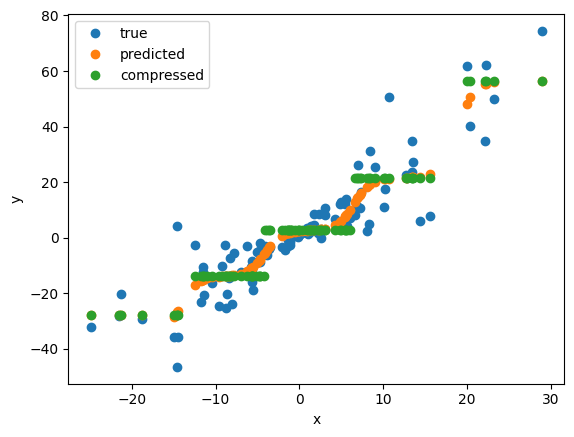

In [14]:
hidden_state, output = combined_model(x.view(-1,1))
hidden_state_compressed, output_compressed = combined_model(x.view(-1,1), eval=True)

plt.figure()
plt.plot(x.numpy(), y.numpy(), 'o', label='true')
plt.plot(x.numpy(), output.detach().numpy(), 'o', label='predicted')
plt.plot(x.numpy(), output_compressed.detach().numpy(), 'o', label='compressed')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [25]:
8**8

16777216

## Test on California Housing Dataset

In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for regression
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
device = 'cuda'

In [17]:
linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
linear_comparison_model.to(device);

In [18]:
a_index = torch.repeat_interleave(torch.arange(8), 8)
quantiles_tensor = torch.tensor([(f+1)*11/100 for f in range(8)])
a_init = torch.quantile(X_train_tensor, quantiles_tensor, dim = 0).T.flatten()

In [19]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [20]:
def eval_val(model, val_dataloader, eval= False, device = 'cuda'):
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            if eval:
                hidden_state, output = model(x, eval=True)    
            else:    
                output = model(x) 
                if isinstance(output, tuple):
                    output = output[1]
            loss = criterion(output, y)
            losses.append(loss.item())
        return np.mean(losses)

In [21]:
def train_comparison(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result = True):
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        val_loss = eval_val(model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss        

In [22]:
def train_combined(combined_model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result=True):
    factor = 0.001 ** (1/num_epochs)
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            hidden_state, output = combined_model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        combined_model.compressed_model.tau = max(combined_model.compressed_model.tau * factor, 0.001)    
        val_loss = eval_val(combined_model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss     

In [23]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
n_epochs = 20
train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs)

Epoch 1/20, Loss: 0.6641232028834579, Val Loss: 0.4167023092508316
Epoch 3/20, Loss: 0.3545344443053238, Val Loss: 0.34922965994248023
Epoch 5/20, Loss: 0.32947696959094486, Val Loss: 0.33669161383922286
Epoch 7/20, Loss: 0.30876109431418336, Val Loss: 0.304209745159516
Epoch 9/20, Loss: 0.2959372698683147, Val Loss: 0.3089138182309958
Epoch 11/20, Loss: 0.2965553893252861, Val Loss: 0.29116448095211617
Epoch 13/20, Loss: 0.28335571136007937, Val Loss: 0.28869829177856443
Epoch 15/20, Loss: 0.2858346630783044, Val Loss: 0.2854492783546448
Epoch 17/20, Loss: 0.27287057934458864, Val Loss: 0.3108562905054826
Epoch 19/20, Loss: 0.26736914349156754, Val Loss: 0.28683845171561606


0.2875490801838728

In [ ]:
## Train combined model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
n_epochs = 20
train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs)

Epoch 1/20, Loss: 0.8726326792046081, Val Loss: 0.6400056109978602
Epoch 3/20, Loss: 0.48576825019694114, Val Loss: 0.5510800733016088
Epoch 5/20, Loss: 0.4016409876734711, Val Loss: 0.4933319811637585
Epoch 7/20, Loss: 0.33754423740067224, Val Loss: 0.41488722333541284
Epoch 9/20, Loss: 0.30989996621081994, Val Loss: 0.36263125607600577
Epoch 11/20, Loss: 0.29493187679800875, Val Loss: 0.29508004922133224
Epoch 13/20, Loss: 0.2800195528728555, Val Loss: 0.29278688774659084
Epoch 15/20, Loss: 0.2827300336933875, Val Loss: 0.29808917469703233
Epoch 17/20, Loss: 0.2799949208779853, Val Loss: 0.29933015612455516
Epoch 19/20, Loss: 0.28190073821433753, Val Loss: 0.3048915560428913


0.3056144267320633

In [25]:
eval_val(linear_comparison_model, test_loader), eval_val(combined_model, test_loader), eval_val(combined_model, test_loader, eval=True)

(0.2875490801838728, 0.3056144267320633, 0.3088066678780776)

In [26]:
def eval_compression(model, val_dataloader, device = 'cuda'):
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            hidden_state, output = model(x)   
            hidden_state_compressed = torch.round(hidden_state) 
            loss = torch.mean(torch.abs(hidden_state - hidden_state_compressed))
            losses.append(loss.item())
        return np.mean(losses)

In [27]:
eval_compression(combined_model, test_loader)

0.001206703527042499

## Evaluate multiple trainings

In [ ]:
val_losses_comparison = []
for f in tqdm(range(20)):
    linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
    linear_comparison_model.to(device);
    n_epochs=40
    optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False)
    val_losses_comparison.append(val_loss_current)
    

100%|██████████| 20/20 [06:07<00:00, 18.39s/it]


In [29]:
val_losses_combined = []
val_losses_compressed = []
for f in tqdm(range(20)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = 64,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    n_epochs=40
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False)
    val_losses_combined.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval = True)
    val_losses_compressed.append(val_loss_current)
    

100%|██████████| 20/20 [06:34<00:00, 19.70s/it]


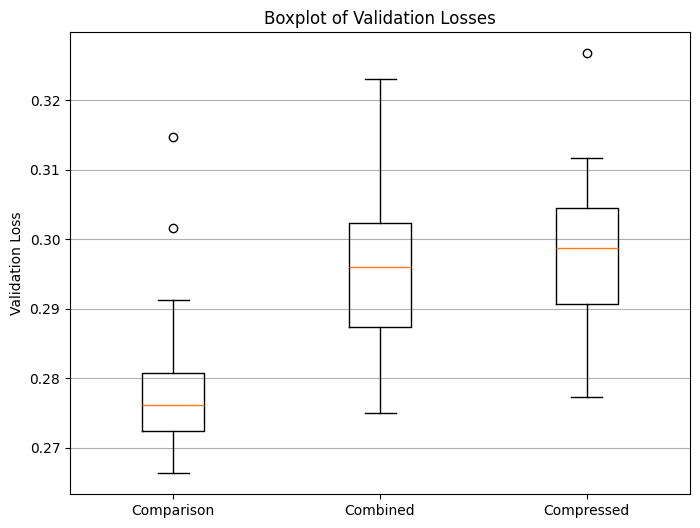

In [30]:
plt.figure(figsize=(8, 6))
plt.boxplot([val_losses_comparison, val_losses_combined, val_losses_compressed], labels=['Comparison', 'Combined', 'Compressed'])
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()

## Plot models decision boundaries

Text(0.5, 1.0, 'Initial Decision Steps')

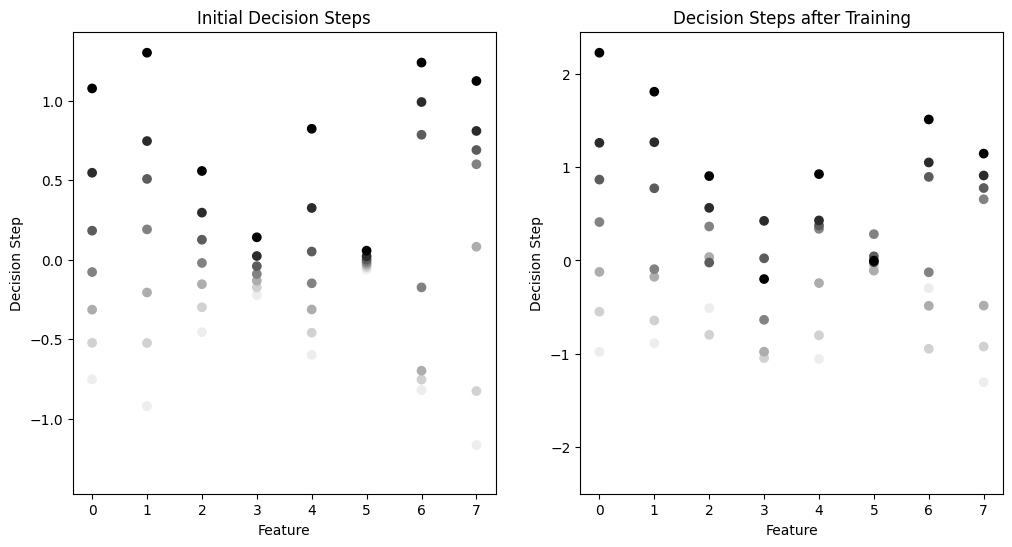

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,2)
for f in range(8):
    plt.scatter(f*np.ones(8), combined_model.compressed_model.a[f*8:(f+1)*8].detach().cpu().numpy(), c = np.arange(8), cmap= 'Greys')
plt.xticks(np.arange(8), np.arange(8)) 
plt.xlabel('Feature')
plt.ylabel('Decision Step')
plt.title('Decision Steps after Training')

plt.subplot(1,2,1)
for f in range(8):
    plt.scatter(f*np.ones(8), a_init[f*8:(f+1)*8],  c = np.arange(8), cmap= 'Greys')
plt.xticks(np.arange(8), np.arange(8)) 
plt.xlabel('Feature')
plt.ylabel('Decision Step')
plt.title('Initial Decision Steps')

## Comparison Trees

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")


Random Forest MSE: 0.47345772327303354


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=256, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 0.6027969396916061


In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")

Decision Tree MSE: 0.4972838079675652


## Test Linear Regression Model

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

Linear Regression MSE: 0.5558915986952442


In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the linear regression model
poly_linear_model = LinearRegression()
poly_linear_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_poly = poly_linear_model.predict(X_test_poly)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f"Polynomial Linear Regression MSE: {mse_poly}")

Polynomial Linear Regression MSE: 0.46430152383011586


In [50]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the Lasso Linear Regression model
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test_poly)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Linear Regression MSE: {mse_lasso}")

Lasso Linear Regression MSE: 0.6135867129893572


## Include extra loss (does not work)

In [39]:
class extra_loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, hidden_state, output, target):
        mse = torch.mean((output - target)**2)
        compress_loss = torch.mean(torch.sqrt(hidden_state * (1- hidden_state)))
        return mse + 0*compress_loss

In [40]:
x.shape

torch.Size([100, 1])

In [41]:
compressed_model_new = CompressedModel(a_init, a_index)
linear_model_new = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 3)
combined_model_new = CombinedModel(compressed_model_new, linear_model_new)
combined_model_new.to(device);

In [42]:
loss_fn = extra_loss()
x,y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)
hidden_state, output  = combined_model_new(x)
loss_fn(hidden_state, output, y)

tensor(6.7879, device='cuda:0', grad_fn=<AddBackward0>)

In [43]:
mse = torch.mean((output - y)**2)
compress_loss = torch.mean(torch.sqrt(hidden_state * (1- hidden_state)))
alt = torch.mean(torch.abs(hidden_state - torch.round(hidden_state)))
mse, compress_loss, alt 

(tensor(6.7879, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4561, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>))

In [44]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.0001)
n_epochs = 100
device= 'cuda'
combined_model.to(device);

for epoch in range(n_epochs):
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        hidden_state, output = combined_model_new(x)
        loss = loss_fn(hidden_state, output, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # combined_model.compressed_model.tau = combined_model.compressed_model.tau* 0.95    
    if epoch % (n_epochs//10) == 0:
        print(f'{epoch}: {np.mean(losses)}')

0: nan
10: nan
20: nan
30: nan
40: nan
50: nan
60: nan
70: nan
80: nan
90: nan


In [45]:
losses

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [46]:
combined_model.compressed_model.a

Parameter containing:
tensor([-1.9696, -0.9794, -0.5497, -0.1231,  0.4115,  0.8664,  1.2608,  2.2268,
        -2.2758, -0.8868, -0.6436, -0.1756, -0.0936,  0.7734,  1.2676,  1.8089,
        -1.0751, -0.5113, -0.7970,  0.0364,  0.3640, -0.0227,  0.5638,  0.9044,
        -1.0487, -0.9868, -1.0466, -0.9779, -0.6364,  0.0229,  0.4242, -0.1994,
        -1.7614, -1.0569, -0.8033, -0.2427,  0.3389,  0.3753,  0.4289,  0.9254,
         0.0083, -0.0386, -0.0599, -0.1098,  0.2819,  0.0442, -0.0171, -0.0025,
        -0.4996, -0.2970, -0.9470, -0.4866, -0.1267,  0.8954,  1.0503,  1.5113,
        -1.3973, -1.3051, -0.9235, -0.4843,  0.6559,  0.7762,  0.9105,  1.1454],
       device='cuda:0', requires_grad=True)

In [47]:
hidden_state[0,16:24]

tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [48]:
[torch.min(params) for params in combined_model.linear_model.parameters()]

[tensor(-1.9710, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.1988, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.3893, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5608, device='cuda:0', grad_fn=<MinBackward1>)]

In [49]:
combined_model.linear_model(hidden_state)

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward